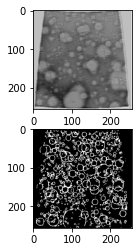

In [48]:
%run main.py

In [87]:

unet.inc.double_conv[0].weight.data = nn.Parameter(torch.Tensor(deepmoon.weights[0].numpy().reshape(112, 1, 3, 3)))
unet.inc.double_conv[0].bias.data = nn.Parameter(torch.Tensor(deepmoon.weights[1].numpy()))
unet.inc.double_conv[2].weight.data = nn.Parameter(torch.Tensor(deepmoon.weights[2].numpy().reshape(112, 112, 3, 3)))
unet.inc.double_conv[2].bias.data = nn.Parameter(torch.Tensor(deepmoon.weights[3].numpy()))

In [105]:
for (name, param), w in zip(unet.named_parameters(), deepmoon.weights):
    if len(param.shape) == 4:
        param.data = nn.Parameter(torch.Tensor(w.numpy().transpose(3, 2, 1, 0)))
    else:
        param.data = nn.Parameter(torch.Tensor(w.numpy()))

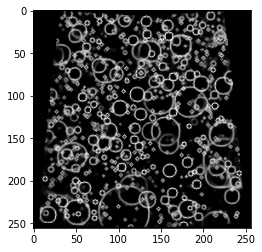

In [107]:
out = unet(transforms.ToTensor()(img).unsqueeze_(0))
plt.imshow(out.detach().squeeze(), cmap='Greys_r')